In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib.inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

UsageError: Line magic function `%matplotlib.inline` not found.


In [2]:
df = pd.read_csv('Alcohol_Sales.csv', index_col=0,parse_dates=True)

In [3]:
df.tail()

,S4248SM144NCEN
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


In [4]:
df = df.dropna()

<AxesSubplot:xlabel='DATE'>

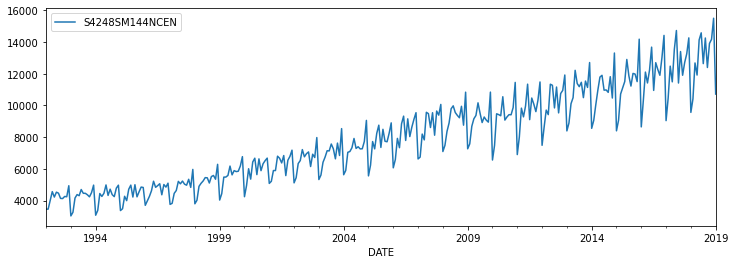

In [5]:
df.plot(figsize=(12,4))

In [6]:
y = df['S4248SM144NCEN'].values.astype(float)

In [7]:
test_size = 12

In [8]:
train_set = y[:-test_size]

In [9]:
test_set = y[-test_size:]

In [10]:
# training and test sets are numpy arrays...
# as we need to transform the data
# but later on we will transform them to tensors as before
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [17]:
# normalise the dataset.

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [13]:
scaler.fit(train_set.reshape(-1, 1))

MinMaxScaler(feature_range=(-1, 1))

In [14]:
train_norm = scaler.transform(train_set.reshape(-1, 1))

In [24]:
# train_norm

In [26]:
# formula to decide size of train size: len(y) - test_size - window_size

In [15]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [16]:
window_size = 12

In [17]:
def input_data(seq, ws):
    '''
    @param: seq = sequence
    @param: ws = window_size
    
    This returns a list of tuples. 
    This is the training data split into batches for training + prediction
    '''
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
    return out

In [18]:
train_data = input_data(train_norm, window_size)

In [19]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

# LSTM

In [20]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size 
        
        # Add an LSTM Layer: 
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        # Add a fully connected layer: 
        self.linear = nn.Linear(hidden_size, output_size)
        
        # Initialize h0 and c0: 
        self.hidden = (torch.zeros(1,1,self.hidden_size), 
                       torch.zeros(1,1,self.hidden_size))
        
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq), -1))
        return pred[-1] # we only want the last value

In [21]:
torch.manual_seed(101)

model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

# Train LSTM

In [25]:
epochs = 100

In [26]:
import time 
start_time = time.time()

for epoch in range(epochs):
    
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (
            torch.zeros(1,1,model.hidden_size),
            torch.zeros(1,1,model.hidden_size)
        )
        
        y_pred = model(seq) 
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch} Loss {loss.item()}')


total_time = time.time() - start_time
print(total_time/60)

Epoch 0 Loss 0.2531021535396576
Epoch 1 Loss 0.3753201365470886
Epoch 2 Loss 0.390271931886673
Epoch 3 Loss 0.34934717416763306
Epoch 4 Loss 0.33085644245147705
Epoch 5 Loss 0.33229973912239075
Epoch 6 Loss 0.3267034888267517
Epoch 7 Loss 0.3207414448261261
Epoch 8 Loss 0.30653542280197144
Epoch 9 Loss 0.2951802909374237
Epoch 10 Loss 0.2693435549736023
Epoch 11 Loss 0.25998514890670776
Epoch 12 Loss 0.2466581016778946
Epoch 13 Loss 0.2240416258573532
Epoch 14 Loss 0.18602551519870758
Epoch 15 Loss 0.18561333417892456
Epoch 16 Loss 0.17209412157535553
Epoch 17 Loss 0.25162041187286377
Epoch 18 Loss 0.22557669878005981
Epoch 19 Loss 0.17450085282325745
Epoch 20 Loss 0.20237016677856445
Epoch 21 Loss 0.20815762877464294
Epoch 22 Loss 0.1664412021636963
Epoch 23 Loss 0.1760096698999405
Epoch 24 Loss 0.11979224532842636
Epoch 25 Loss 0.09577062726020813
Epoch 26 Loss 0.04544166103005409
Epoch 27 Loss 0.059266939759254456
Epoch 28 Loss 0.003294221591204405
Epoch 29 Loss 0.11085526645183563


In [27]:
future = 12 

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        preds.append(model(seq).item())

In [28]:
preds[window_size:]

[0.17316967248916626,
 0.6589337587356567,
 0.4075621962547302,
 0.8163197040557861,
 0.9906359314918518,
 0.4274939298629761,
 0.828018069267273,
 0.49622225761413574,
 0.7134068608283997,
 0.6823556423187256,
 0.7813570499420166,
 0.1975398063659668]

In [31]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [35]:
true_predictions

array([[ 9893.45599923],
       [12734.93302172],
       [11264.53506699],
       [13655.56210887],
       [14675.22488126],
       [11381.12574273],
       [13723.99169618],
       [11783.15209591],
       [13053.57343242],
       [12871.93932974],
       [13451.04806364],
       [10036.00909734]])

In [34]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [36]:
x = np.arange('2018-02-01','2019-02-01',dtype='datetime64[M]')

In [37]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

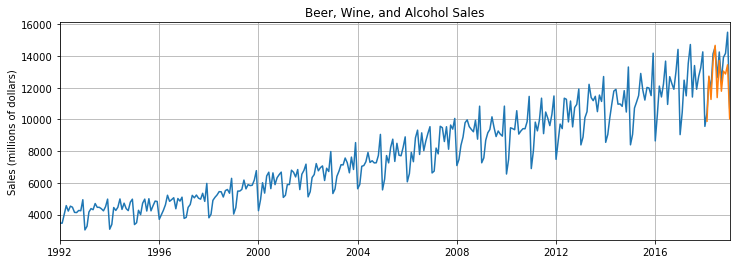

In [43]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

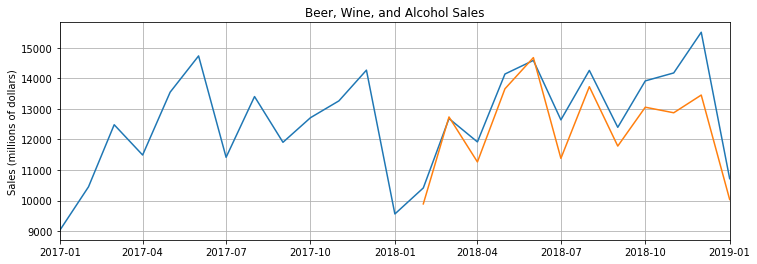

In [45]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()